### Vibe of each Seattle neighborhood using listing descriptions and sentiment analysis

In [1]:
# Import necessary libraries
import pandas as pd
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import pipeline
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('listings.csv')

# Taking only the required columns
df=df[['neighborhood_overview', 'notes', 'transit', 'neighbourhood_cleansed']]
df.head()

,neighborhood_overview,notes,transit,neighbourhood_cleansed
0,NaN,NaN,NaN,West Queen Anne
1,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",West Queen Anne
2,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,West Queen Anne
3,NaN,NaN,NaN,West Queen Anne
4,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,West Queen Anne


In [2]:
# Combining the 3 columns to a single column to calculate a single sentiment score for each property
df['merged_sentiment'] = (df['neighborhood_overview'].fillna('').astype(str) + ' ' + df['notes'].fillna('').astype(str) + ' ' + df['transit'].fillna('').astype(str)).str.slice(0, 512)

# df.head()

In [3]:
# Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

# Using CUDA for faster results
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Create a pipeline for sentiment analysis
sentiment_analysis = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=0 if device == 'cuda' else -1)

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

c:\Users\hp\AppData\Local\Programs\Python\Python39\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\hp\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [4]:
# Example usage
result = sentiment_analysis("I would love to work at Decentro!")
print(result)

[{'label': 'POSITIVE', 'score': 0.9972144961357117}]


In [5]:
def get_sentiment(text):
    result = sentiment_analysis(text)[0]
    return pd.Series([result['label'], result['score']])

# Apply the function to the DataFrame
# Takes about 35 seconds on CUDA, and about 5 minutes on CPU
df[['sentiment_class', 'sentiment_score']] = df['merged_sentiment'].apply(get_sentiment)


In [6]:
# df.head()

In [7]:
# Calculate average sentiment score for each neighbourhood
average_scores = df[df['sentiment_class'] == 'POSITIVE'].groupby('neighbourhood_cleansed')['sentiment_score'].mean()

In [8]:
average_scores.head()

neighbourhood_cleansed
Adams            0.962849
Alki             0.923637
Arbor Heights    0.923060
Atlantic         0.905296
Belltown         0.898488
Name: sentiment_score, dtype: float64

In [9]:
#Sorting the sentiment scores and extracting the top 10 neighbourhoods
sorted_neighbourhoods = average_scores.sort_values(ascending=False)

sorted_list = list(sorted_neighbourhoods)
top_10 = sorted_neighbourhoods.head(10)
top_10

neighbourhood_cleansed
Pinehurst             0.997660
Roxhill               0.997412
Interbay              0.992247
South Beacon Hill     0.992180
Portage Bay           0.988687
Fairmount Park        0.987982
Montlake              0.982003
North College Park    0.974895
Brighton              0.971477
Fauntleroy            0.966885
Name: sentiment_score, dtype: float64

In [10]:
# Barchart
# Plot the top 10 neighbourhoods
# plt.figure(figsize=(12, 8))
# top_10.plot(kind='barh', color='skyblue')
# plt.xlabel('Average Sentiment Score')
# plt.ylabel('Neighbourhood')
# plt.title('Top 10 Neighbourhood by Sentiment Score')
# plt.gca().invert_yaxis()
# plt.show()

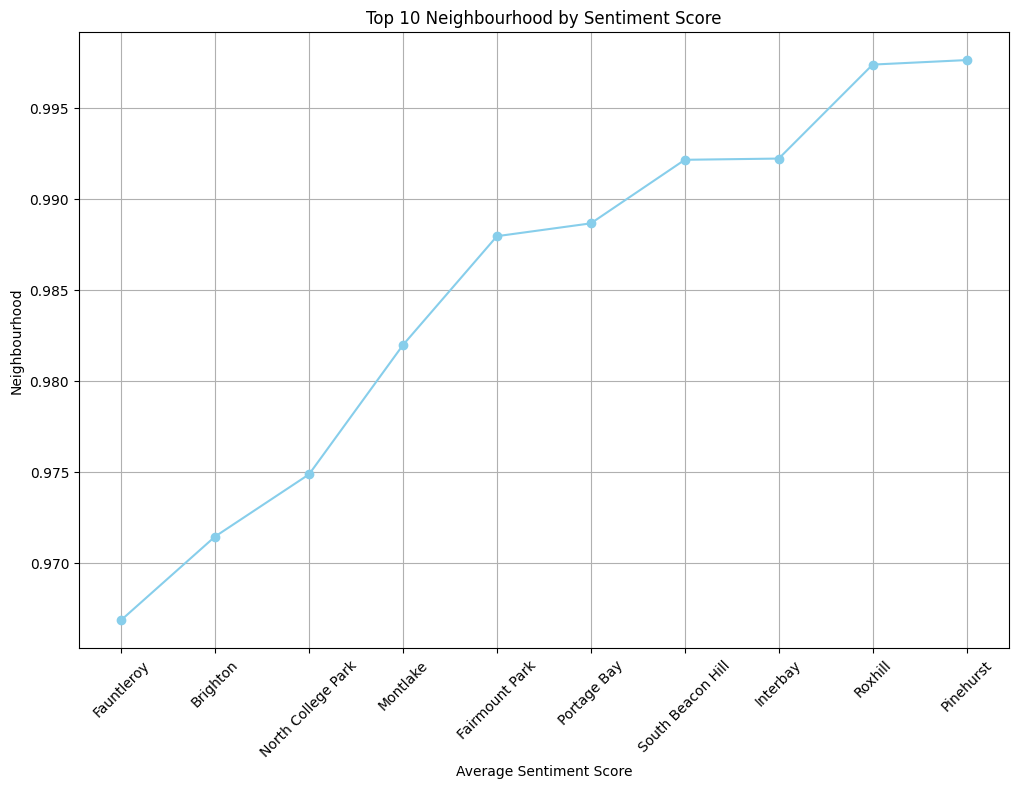

In [11]:
# Plot the top 10 lands
plt.figure(figsize=(12, 8))
plt.plot(top_10.index, top_10.values, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Neighbourhood')
plt.title('Top 10 Neighbourhood by Sentiment Score')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.gca().invert_xaxis()  # Invert x-axis to have the highest scores on the right

plt.grid(True)
plt.show()

### Vibe of each Seattle neighborhood using listing descriptions and frequently used words

In [12]:
# Load the data
data = pd.read_csv('listings.csv')

# Taking only the required columns
data=data[['neighborhood_overview', 'notes', 'transit', 'neighbourhood_cleansed']]
data['merged_sentiment'] = (data['neighborhood_overview'].fillna('').astype(str) + ' ' + data['notes'].fillna('').astype(str) + ' ' + data['transit'].fillna('').astype(str)).str.slice(0, 512)

data.head()

,neighborhood_overview,notes,transit,neighbourhood_cleansed,merged_sentiment
0,NaN,NaN,NaN,West Queen Anne,
1,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,"Convenient bus stops are just down the block, ...",West Queen Anne,"Queen Anne is a wonderful, truly functional vi..."
2,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,A bus stop is just 2 blocks away. Easy bus a...,West Queen Anne,Upper Queen Anne is a charming neighborhood fu...
3,NaN,NaN,NaN,West Queen Anne,
4,We are in the beautiful neighborhood of Queen ...,Belltown,The nearest public transit bus (D Line) is 2 b...,West Queen Anne,We are in the beautiful neighborhood of Queen ...


In [13]:
# Word frequency analysis
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english')

grouped = data.groupby('neighbourhood_cleansed')['merged_sentiment'].apply(lambda x: ' '.join(x))


In [14]:
import numpy as np
from collections import Counter
# Initialize a dictionary to hold results
top_words = {}

# Process each neighborhood group
for neighbourhood, text in grouped.items():
    # Transforming the text data to a matrix of token counts
    X = vectorizer.fit_transform([text])

    # Getting feature names and count data
    words = vectorizer.get_feature_names_out()
    counts = np.asarray(X.sum(axis=0)).flatten()

    # Creating a dictionary of word counts
    word_counts = dict(zip(words, counts))

    # Getting the 5 most frequent words
    most_frequent_words = [word for word, count in Counter(word_counts).most_common(5)]

    # Joining words by comma
    top_words[neighbourhood] = ', '.join(most_frequent_words)

In [15]:
# Create a DataFrame from the dictionary
result_data = pd.DataFrame(list(top_words.items()), columns=['neighbourhood_cleansed', 'top_5_words'])
result_data.head()


,neighbourhood_cleansed,top_5_words
0,Adams,"ballard, seattle, downtown, restaurants, walk"
1,Alki,"beach, seattle, alki, restaurants, neighborhood"
2,Arbor Heights,"cruise, bus, close, beach, downtown"
3,Atlantic,"downtown, hill, bus, seattle, away"
4,Belltown,"seattle, place, center, downtown, walk"


### Thank You!!